In [1]:
import os

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import glob

from pathlib import Path

import scipy.stats as stats

from scipy import stats

import ruptures as rpt

In [2]:
def difference_values_general_45ssp3(input_BA): # do input_BA as string e.g. 'AEC'
    
    # create list of files to unpack for hot and cold scenario
    list_hot_files = glob.glob(os.path.join(r'C:\projects\rcp45hotter_ssp3', f'{input_BA}_*.csv'))
    list_cold_files = glob.glob(os.path.join(r'C:\projects\rcp45cooler_ssp3', f'{input_BA}_*.csv'))
    
    # get monthly chunks of data
    list_diff_means = []
    for file_index in range(len(list_hot_files)):
        
        # read in yearly data as df
        hot_year_df = pd.read_csv(list_hot_files[file_index], index_col = None, header = 0)
        cold_year_df = pd.read_csv(list_cold_files[file_index], index_col = None, header = 0)
        
        # add months column, cold T2 column, and T2 difference column to hot_year_df
        hot_year_df['Month'] = pd.DatetimeIndex(hot_year_df['Time_UTC']).month
        cold_year_df['Month'] = pd.DatetimeIndex(cold_year_df['Time_UTC']).month
        hot_year_df['Cold_T2'] = cold_year_df['T2']
        hot_year_df['T2_Diff'] = hot_year_df['T2'] - hot_year_df['Cold_T2']
        
        # create the monthly dfs for hot and cold
        hot_df1 = hot_year_df[hot_year_df['Month'] == 1]
        hot_df2 = hot_year_df[hot_year_df['Month'] == 2]
        hot_df3 = hot_year_df[hot_year_df['Month'] == 3]
        hot_df4 = hot_year_df[hot_year_df['Month'] == 4]
        hot_df5 = hot_year_df[hot_year_df['Month'] == 5]
        hot_df6 = hot_year_df[hot_year_df['Month'] == 6]
        hot_df7 = hot_year_df[hot_year_df['Month'] == 7]
        hot_df8 = hot_year_df[hot_year_df['Month'] == 8]
        hot_df9 = hot_year_df[hot_year_df['Month'] == 9]
        hot_df10 = hot_year_df[hot_year_df['Month'] == 10]
        hot_df11 = hot_year_df[hot_year_df['Month'] == 11]
        hot_df12 = hot_year_df[hot_year_df['Month'] == 12]
        
        # create a list to iterate over the monthly dfs
        hot_monthly_list = [hot_df1, hot_df2, hot_df3, hot_df4, hot_df5, hot_df6, hot_df7, hot_df8, hot_df9, hot_df10, hot_df11, hot_df12]
        
        for month_df in hot_monthly_list:
            
            # add the mean of the monthly diff values to list
            list_diff_means.append(month_df['T2_Diff'].mean())
            
        if len(list_diff_means) == 840:
            break
            
    # create df from the list of top 5% difference means
    diff_means_df = pd.DataFrame(list_diff_means, columns = ['Mean_Difference'])
    
    # create list of years to add to df
    years_list = [range(2020, 2090)]
    years_list_repeated = np.repeat(years_list, 12)
    diff_means_df['Year'] = years_list_repeated
    
    # create months index to add to df
    months_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
    months_list_repeated = months_list * 70
    diff_means_df['Month'] = months_list_repeated
    
    months_index = pd.date_range(start = '2020-01', end = '2090-01', freq = 'M')
    diff_means_df['Index'] = months_index
    
    # reorganize columns
    diff_means_df = diff_means_df[['Index', 'Year', 'Month', 'Mean_Difference']]
        
    return diff_means_df  # len of list is 960, so a monthly mean value over 80 years of data

In [3]:
# create the df to do changepoint detection on
aec_test = difference_values_general_45ssp3('AVA')

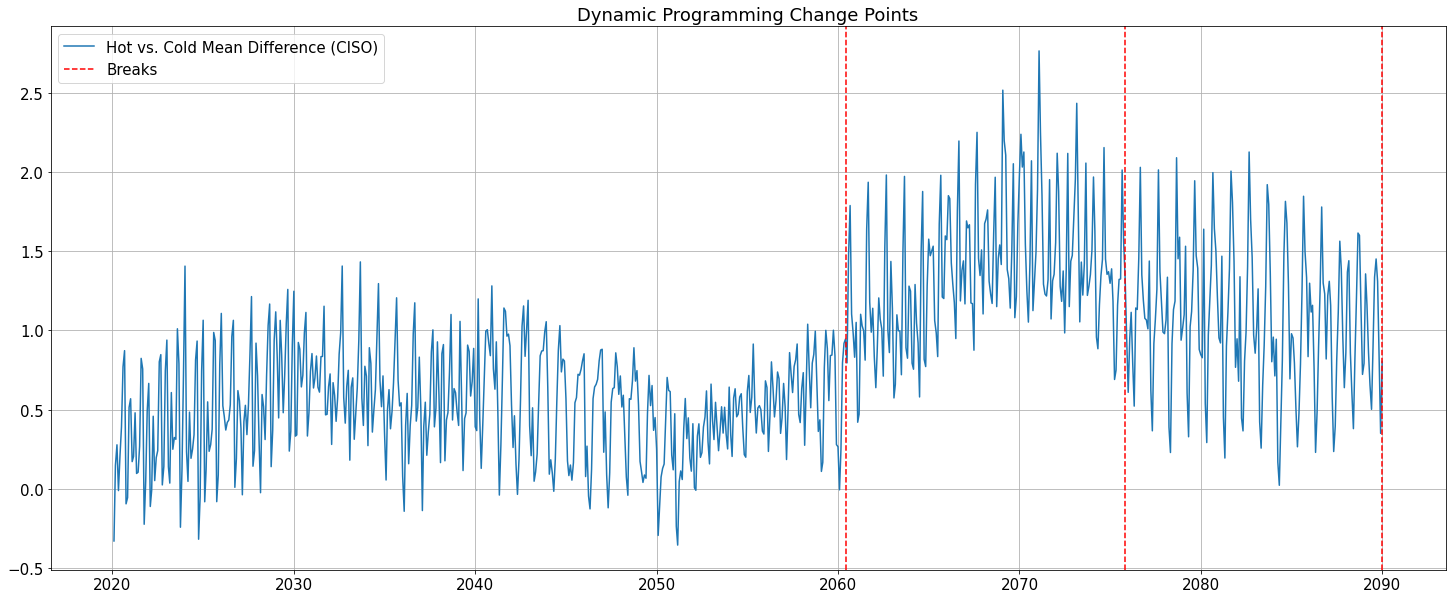

In [4]:
# trying the dynamic programming search method
# convert Index to date-time and get time-series
aec_test['Date'] = pd.to_datetime(aec_test['Index'])
aec_test.set_index(aec_test['Date'], inplace = True)
mean_ts = aec_test['Mean_Difference']

# convert time series array to list
mean_list = np.array(mean_ts.tolist())

# estimate number of breaks
n_breaks = 3  # what are the criteria here?

# decide on the model ("l1", "l2", or "rbf" i.e. Gaussian) and apply the search method
model = rpt.Dynp(model = "l1")

# fit() takes the time-series list as input and fits the algorithm to the data
model.fit(mean_list)

# predict() works on top of trained model to predict the labels for the test data
breaks = model.predict(n_bkps = n_breaks - 1)

# create list of the indexes where breaks occur
breaks_rpt = []
for i in breaks:
    breaks_rpt.append(mean_ts.index[i-1])
breaks_rpt = pd.to_datetime(breaks_rpt)

# plot the breaks from the dynp search method
plt.figure(figsize=(25, 10))
plt.rcParams['font.size'] = 15
plt.plot(mean_ts, label = 'Hot vs. Cold Mean Difference (CISO)')
plt.title('Dynamic Programming Change Points')
print_legend = True
for i in breaks_rpt:
    if print_legend:
        plt.axvline(i, color = 'red', linestyle = 'dashed', label = 'Breaks')
        print_legend = False
    else:
        plt.axvline(i, color = 'red', linestyle = 'dashed')
plt.grid()
plt.legend()
plt.show()

[470, 535, 670, 840]


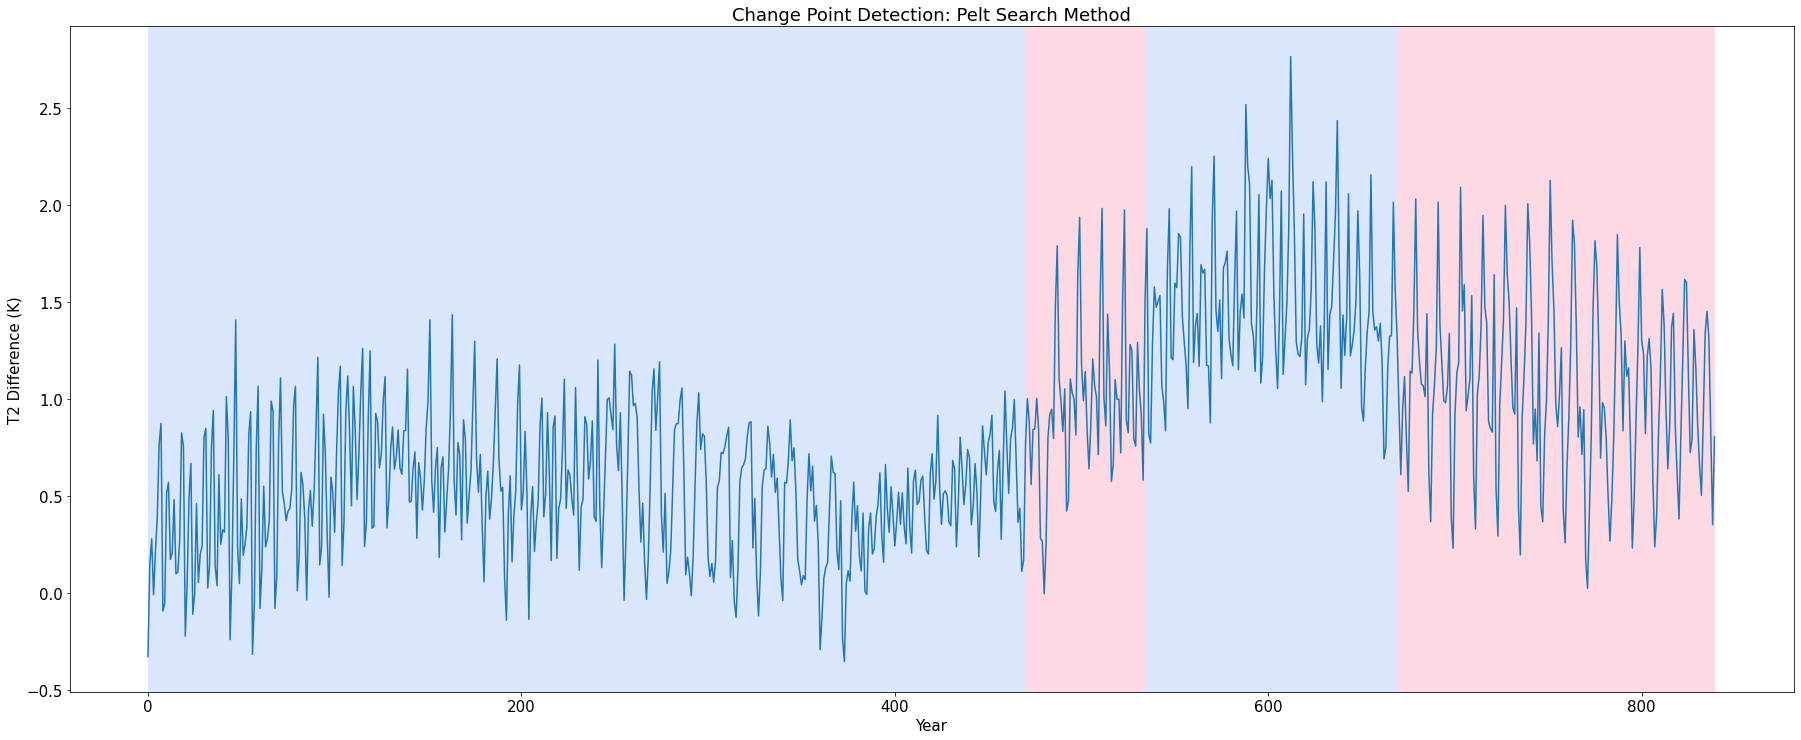

In [5]:
model="l1"
algo = rpt.Pelt(model = model).fit(mean_list)
result = algo.predict(pen = 4)
print(result)
rpt.display(mean_ts, result, figsize=(25, 10))
plt.rcParams['font.size'] = 15
plt.title('Change Point Detection: Pelt Search Method')
plt.xlabel('Year')
plt.ylabel('T2 Difference (K)')
plt.show()

In [6]:
# time to start again, define a new function to get the monthly means based on Casey code
# Set the balancing authority to analyze:
# ba_to_plot = 'CISO'

# set path
# cooler_dir = r'C:\projects\rcp85cooler_ssp3'
# hotter_dir = r'C:\projects\rcp85hotter_ssp3'
# image_output_dir = r'C:\projects\images'

In [87]:
def pelt_plot(ba_to_plot):  # ba_to_plot as string, e.g.'AEC'
    
    # call function for particular BA to generate monthly dataframe
    ba_df = difference_values_general_45ssp3(ba_to_plot)
    
    # convert Index to date-time and get time-series
    ba_df['Date'] = pd.to_datetime(ba_df['Index'])
    ba_df.set_index(ba_df['Date'], inplace = True)
    mean_ts = ba_df['Mean_Difference']

    # convert time series array to list
    mean_list = np.array(mean_ts.tolist())
    
    # set model, use algorithm to predict breakpoints within time series
    model="l1"
    algo = rpt.Pelt(model = model).fit(mean_list)
    result = algo.predict(pen = 1)
    print(result)
    
    # plot the resulting breakpoints
    rpt.display(mean_ts, result, figsize=(25, 10))
    plt.rcParams['font.size'] = 15
    plt.title('Change Point Detection: Pelt Search Method')
    plt.xlabel('Year')
    plt.ylabel('T2 Difference (K)')
    
    plt.show()
    
    return

[215, 220, 485, 505, 510, 515, 520, 660, 795, 840]


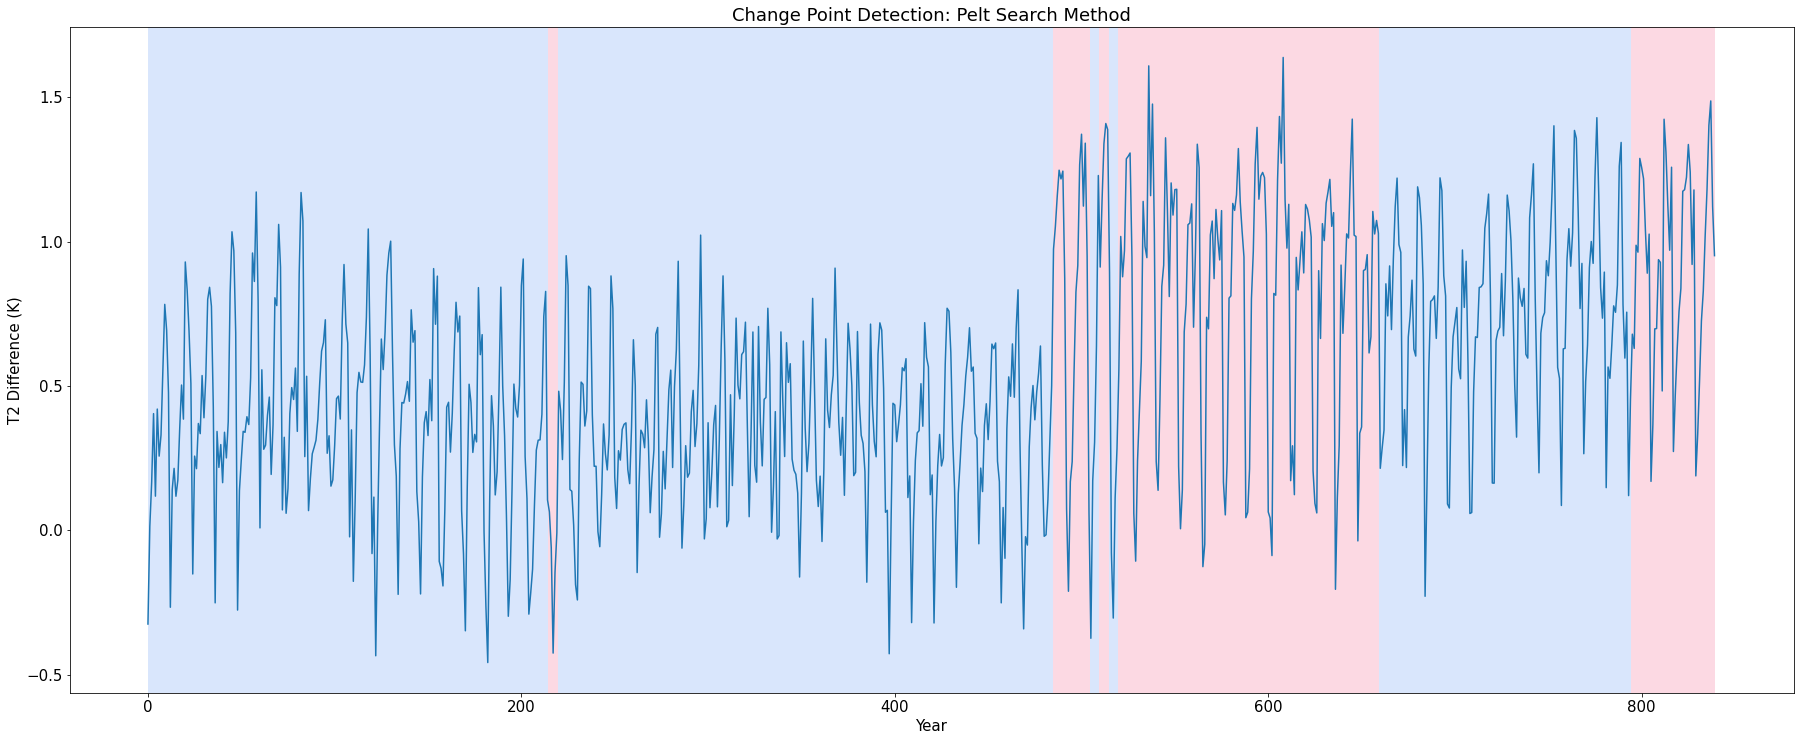

In [88]:
pelt_plot('AEC')

In [23]:
def mean_diff_40(input_BA): # do input_BA as string e.g. 'AEC'
    
    # create list of files to unpack for hot and cold scenario
    list_hot_files = glob.glob(os.path.join(r'C:\projects\rcp45hotter_ssp3', f'{input_BA}_*.csv'))
    list_cold_files = glob.glob(os.path.join(r'C:\projects\rcp45cooler_ssp3', f'{input_BA}_*.csv'))
    
    # get monthly chunks of data
    list_diff_means = []
    for file_index in range(len(list_hot_files)):
        
        # read in yearly data as df
        hot_year_df = pd.read_csv(list_hot_files[file_index], index_col = None, header = 0)
        cold_year_df = pd.read_csv(list_cold_files[file_index], index_col = None, header = 0)
        
        # add months column, cold T2 column, and T2 difference column to hot_year_df
        hot_year_df['Month'] = pd.DatetimeIndex(hot_year_df['Time_UTC']).month
        cold_year_df['Month'] = pd.DatetimeIndex(cold_year_df['Time_UTC']).month
        hot_year_df['Cold_T2'] = cold_year_df['T2']
        hot_year_df['T2_Diff'] = hot_year_df['T2'] - hot_year_df['Cold_T2']
        
        # create the monthly dfs for hot and cold
        hot_df1 = hot_year_df[hot_year_df['Month'] == 1]
        hot_df2 = hot_year_df[hot_year_df['Month'] == 2]
        hot_df3 = hot_year_df[hot_year_df['Month'] == 3]
        hot_df4 = hot_year_df[hot_year_df['Month'] == 4]
        hot_df5 = hot_year_df[hot_year_df['Month'] == 5]
        hot_df6 = hot_year_df[hot_year_df['Month'] == 6]
        hot_df7 = hot_year_df[hot_year_df['Month'] == 7]
        hot_df8 = hot_year_df[hot_year_df['Month'] == 8]
        hot_df9 = hot_year_df[hot_year_df['Month'] == 9]
        hot_df10 = hot_year_df[hot_year_df['Month'] == 10]
        hot_df11 = hot_year_df[hot_year_df['Month'] == 11]
        hot_df12 = hot_year_df[hot_year_df['Month'] == 12]
        
        # create a list to iterate over the monthly dfs
        hot_monthly_list = [hot_df1, hot_df2, hot_df3, hot_df4, hot_df5, hot_df6, hot_df7, hot_df8, hot_df9, hot_df10, hot_df11, hot_df12]
        
        for month_df in hot_monthly_list:
            
            # add the mean of the monthly diff values to list
            list_diff_means.append(month_df['T2_Diff'].mean())
            
        if len(list_diff_means) == 480:
            break
            
    # create df from the list of top 5% difference means
    diff_means_df = pd.DataFrame(list_diff_means, columns = ['Mean_Difference'])
    
    # create list of years to add to df
    years_list = [range(2020, 2060)]
    years_list_repeated = np.repeat(years_list, 12)
    diff_means_df['Year'] = years_list_repeated
    
    # create months index to add to df
    months_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
    months_list_repeated = months_list * 40
    diff_means_df['Month'] = months_list_repeated
    
    months_index = pd.date_range(start = '2020-01', end = '2060-01', freq = 'M')
    diff_means_df['Index'] = months_index
    
    # reorganize columns
    diff_means_df = diff_means_df[['Index', 'Year', 'Month', 'Mean_Difference']]
        
    return diff_means_df  # len of list is 960, so a monthly mean value over 80 years of data

In [80]:
def pelt_plot_test(ba_to_plot):  # ba_to_plot as string, e.g.'AEC'
    
    # call function for particular BA to generate monthly dataframe
    ba_df = mean_diff_40(ba_to_plot)
    
    # convert Index to date-time and get time-series
    ba_df['Date'] = pd.to_datetime(ba_df['Index'])
    ba_df.set_index(ba_df['Date'], inplace = True)
    mean_ts = ba_df['Mean_Difference']

    # convert time series array to list
    mean_list = np.array(mean_ts.tolist())
    
    # set model, use algorithm to predict breakpoints within time series
    model="l1"
    algo = rpt.Pelt(model = model).fit(mean_list)
    result = algo.predict(pen = 1)
    print(result)
    
    # plot the resulting breakpoints
    rpt.display(mean_ts, result, figsize=(25, 10))
    plt.rcParams['font.size'] = 15
    plt.title('Change Point Detection: Pelt Search Method ' + ba_to_plot)
    plt.xlabel('Year')
    plt.ylabel('T2 Difference (K)')
    
    plt.show()
    
    return

[100, 170, 210, 335, 480]


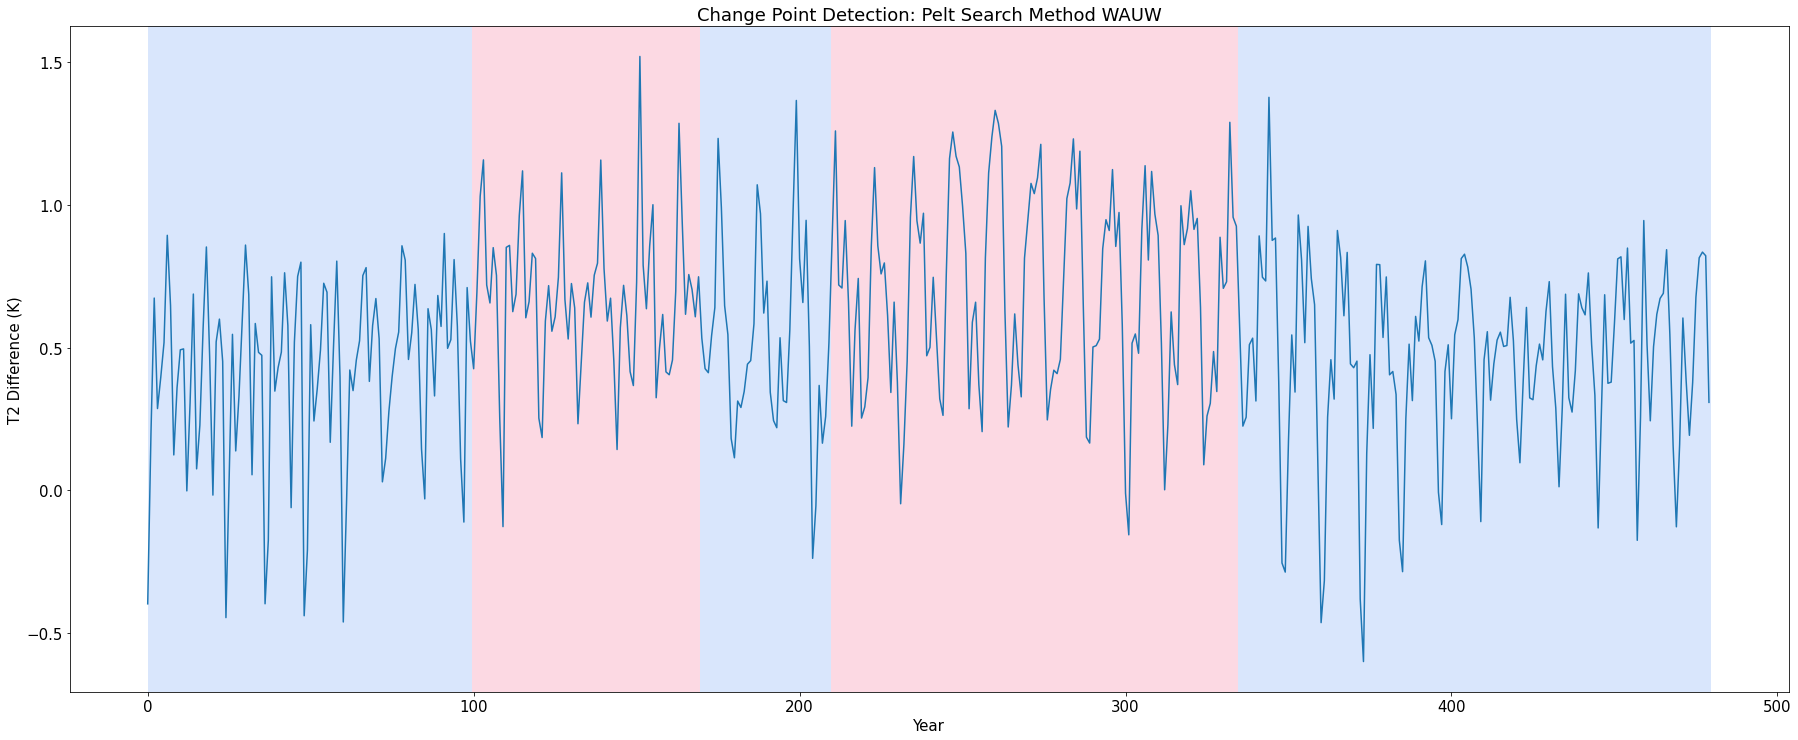

In [89]:
pelt_plot_test('WAUW')

Since the number of changepoints is different for every BA at the same penalty (e.g. penalty = 1), what if we have the function repeatedly run the algorithm with different penalties until we get a certain number of change points detected? That way we detect only the most significant points, and don't let a low penalty give too many change points to a particular BA. But we have the issue of some BA's having NO detected changepoints in the first 40 years, even with pen = 1. Additionally, sometimes when changing the penalty from 2 -> 1, we go from some 6-7 changepoints to 0. So we may need to allow a range of changepoints, like if there we have between 2-6 changepoints, then we accept that and use the first one in the bar graph. 